# Boolean classifier - Logistic Regression (level 0)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from _datetime import date
import numpy as np
import seaborn as sns
import pickle 

from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

In [24]:
#df = pd.read_csv('../01trainingdataset/2020-12-21_datasetBoolean.csv')
#df = pd.read_csv('../01trainingdataset/2021-01-11_datasetCeroLevelBinary.csv')
# df = pd.read_csv('../01trainingdataset/2021-01-16_datasetCeroLevelBinary.csv')
# df = pd.read_csv('../01trainingdataset/2021-01-20_datasetCeroLevelBinary.csv')
df = pd.read_csv('../../01trainingdataset/dataset/2021-06-06_datasetCeroLevelBinary.csv')
df.head()

,source,condition,CEsnippet,Sentence,newTag,binTag,reviewedTag
0,MAYO,Acute kidney failure,Acute kidney failure — also called acute renal...,Acute kidney failure — also called acute renal...,YES,1,DECLINE FAST FROM 1 DAY TO 1 WEEK
1,MAYO,Systemic mastocytosis,"Another type, aggressive systemic mastocytosis...","Another type, aggressive systemic mastocytosis...",YES,1,DECLINE FAST FROM 1 DAY TO 1 WEEK
2,MAYO,Plague,Pneumonic plague progresses rapidly and may ca...,Pneumonic plague progresses rapidly and may ca...,YES,1,DECLINE FAST FROM 1 DAY TO 1 WEEK
3,MAYO,Dermatographia,"Rarely, dermatographia develops more slowly an...","Rarely, dermatographia develops more slowly an...",YES,1,DECLINE FAST FROM 1 DAY TO 1 WEEK
4,NHS,Epiglottitis,The symptoms of epiglottitis usually develop q...,The symptoms of epiglottitis usually develop q...,YES,1,DECLINE FAST FROM 1 DAY TO 1 WEEK


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983 entries, 0 to 1982
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       1983 non-null   object
 1   condition    1983 non-null   object
 2   CEsnippet    1981 non-null   object
 3   Sentence     1983 non-null   object
 4   newTag       1983 non-null   object
 5   binTag       1983 non-null   int64 
 6   reviewedTag  1983 non-null   object
dtypes: int64(1), object(6)
memory usage: 108.6+ KB


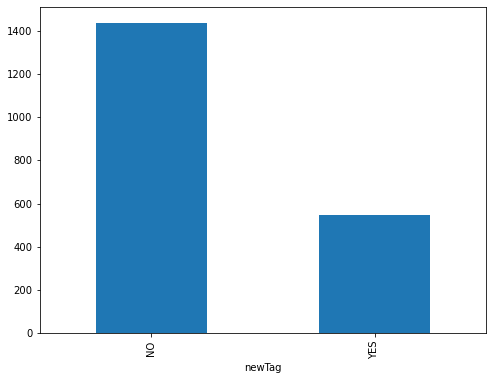

In [26]:
fig = plt.figure(figsize=(8,6))
df.groupby('newTag').Sentence.count().plot.bar(ylim=0)
plt.show()

In [88]:
X = df.Sentence
y = df.binTag
#Changing the test_size parameter from 0.2 to 0.3 improves the accuracy from .79 to .83
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=12)

In [89]:
#class_weight parameter used during model fitting to assing a larger penalty to wrong predictions on the minority class 
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=True,smooth_idf=True,norm='l2')),
                #('clf', linear_model.LogisticRegression(n_jobs=1, C=1e3,solver='newton-cg', multi_class='multinomial',max_iter=1000)),
                ('clf', linear_model.LogisticRegression(n_jobs=1, C=1000,solver='liblinear', multi_class='ovr',max_iter=1000,class_weight='balanced',random_state=12)),
                 #('clf', linear_model.LogisticRegression(n_jobs=1, C=10,solver='lbfgs', multi_class='ovr',max_iter=10000)),
                #('clf', linear_model.LogisticRegression(n_jobs=1, C=10,solver='newton-cg', multi_class='multinomial',max_iter=100,class_weight='balanced')),
               ])


In [90]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    max_iter=1000, multi_class='ovr', n_jobs=1,
                                    random_state=12, solver='liblinear'))])

In [91]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 11.5 ms


In [92]:
#Results
print('accuracy %s' % accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

accuracy 0.8816120906801007
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       288
           1       0.77      0.82      0.79       109

    accuracy                           0.88       397
   macro avg       0.85      0.86      0.85       397
weighted avg       0.88      0.88      0.88       397



In [71]:
newdf = pd.DataFrame({'testSentence': X_test.values})
newdf['testTag'] = y_test.values
newdf['predictedTag'] = y_pred
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   testSentence  595 non-null    object
 1   testTag       595 non-null    int64 
 2   predictedTag  595 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.1+ KB


In [72]:
newdf.testTag.value_counts(dropna=False)

0    431
1    164
Name: testTag, dtype: int64

In [73]:
newdf.predictedTag.value_counts(dropna=False)

0    428
1    167
Name: predictedTag, dtype: int64

In [74]:
newdf.to_csv('01Level0/'+str(date.today())+'_LR_testingDataResult.csv', index = True)

In [75]:
newdf['flag'] = (newdf['testTag'] == newdf['predictedTag'])
flag = [False]
errors = newdf[newdf.flag.isin(flag)]

In [76]:
newdf.flag.value_counts()

True     530
False     65
Name: flag, dtype: int64

# Saving the model

In [77]:
#Save the model
filename = 'models/'+str(date.today())+'_Level0_LR.pkl'
# filename = '2021-01-11_Level0_LR.pkl'
pickle.dump(logreg, open(filename, 'wb'))

In [9]:
#Load the model
filename = '2021-01-11_Level0_LR.pkl'
nb_model_read = pickle.load(open(filename, 'rb'))

In [10]:
for param, value in nb_model_read.get_params(deep=True).items():
    print(f"{param} -> {value}")
# linear_model.LogisticRegression.get_params().keys()

memory -> None
steps -> [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression(C=1000.0, max_iter=4000, multi_class='ovr', n_jobs=1,
                   solver='liblinear'))]
verbose -> False
vect -> CountVectorizer()
tfidf -> TfidfTransformer()
clf -> LogisticRegression(C=1000.0, max_iter=4000, multi_class='ovr', n_jobs=1,
                   solver='liblinear')
vect__analyzer -> word
vect__binary -> False
vect__decode_error -> strict
vect__dtype -> <class 'numpy.int64'>
vect__encoding -> utf-8
vect__input -> content
vect__lowercase -> True
vect__max_df -> 1.0
vect__max_features -> None
vect__min_df -> 1
vect__ngram_range -> (1, 1)
vect__preprocessor -> None
vect__stop_words -> None
vect__strip_accents -> None
vect__token_pattern -> (?u)\b\w\w+\b
vect__tokenizer -> None
vect__vocabulary -> None
tfidf__norm -> l2
tfidf__smooth_idf -> True
tfidf__sublinear_tf -> False
tfidf__use_idf -> True
clf__C -> 1000.0
clf__class_weight -> None
clf__dual -> False
clf_

## Learning curve

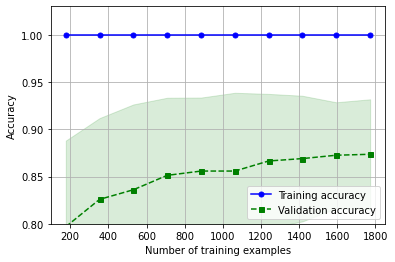

In [8]:
train_sizes, train_scores, test_scores = learning_curve(estimator=logreg, 
                                                        X=X,y=y,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1,shuffle=True)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='Validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

## Validation curve

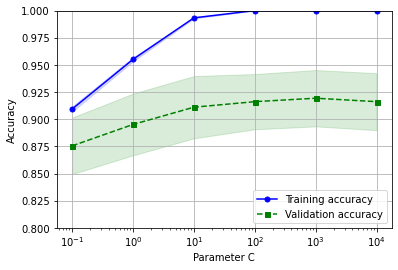

In [35]:
param_range = [0.1,1,10,100,1000,10000]
train_scores, test_scores = validation_curve(estimator=logreg,X=X_train,y=y_train,
                                             param_name='clf__C',param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o',markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

memory -> None
steps -> [('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression(C=1000.0, max_iter=10000, multi_class='ovr', n_jobs=1))]
verbose -> False
vect -> CountVectorizer()
tfidf -> TfidfTransformer()
clf -> LogisticRegression(C=1000.0, max_iter=10000, multi_class='ovr', n_jobs=1)
vect__analyzer -> word
vect__binary -> False
vect__decode_error -> strict
vect__dtype -> <class 'numpy.int64'>
vect__encoding -> utf-8
vect__input -> content
vect__lowercase -> True
vect__max_df -> 1.0
vect__max_features -> None
vect__min_df -> 1
vect__ngram_range -> (1, 1)
vect__preprocessor -> None
vect__stop_words -> None
vect__strip_accents -> None
vect__token_pattern -> (?u)\b\w\w+\b
vect__tokenizer -> None
vect__vocabulary -> None
tfidf__norm -> l2
tfidf__smooth_idf -> True
tfidf__sublinear_tf -> False
tfidf__use_idf -> True
clf__C -> 1000.0
clf__class_weight -> None
clf__dual -> False
clf__fit_intercept -> True
clf__intercept_scaling -> 1
clf__l1_ratio -> None
clf

# Review statistics

In [30]:
dfstats = pd.read_csv('02LR/02'+str(date.today())+'_GroupedPredicted.csv')
dfstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6262 entries, 0 to 6261
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   conditionName  6262 non-null   object 
 1   predictedTag   6262 non-null   object 
 2   Unnamed: 0     6262 non-null   int64  
 3   Unnamed: 0.1   5672 non-null   float64
 4   source         6262 non-null   int64  
 5   sentence       6262 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 293.7+ KB


In [31]:
dfstats.head()

,conditionName,predictedTag,Unnamed: 0,Unnamed: 0.1,source,sentence
0,AAA,IMPROVE MODERATELY FROM * WEEK TO * MONTH,2,2.0,2,2
1,AAA,IMPROVE MODERATELY FROM * WEEK TO * WEEK,1,1.0,1,1
2,AAA,NONE,115,115.0,115,115
3,AAA screening,IMPROVE FAST FROM * MINUTES TO * MINUTES,1,1.0,1,1
4,AAA screening,IMPROVE MODERATELY FROM * WEEK TO * WEEK,1,1.0,1,1


In [32]:
#number of tags by condition
dftbc = dfstats['conditionName'].value_counts().reset_index()#.to_dict()
dftbc.columns = ['conditionName', 'numberOfTags']
print(dftbc)

                             conditionName  numberOfTags
0                                  Obesity            11
1                   Traumatic brain injury            11
2                              Common cold            10
3                               Meningitis            10
4                               Concussion            10
...                                    ...           ...
2019       Primary lateral sclerosis (PLS)             1
2020              Body dysmorphic disorder             1
2021  Hip pain in children (irritable hip)             1
2022             Maple syrup urine disease             1
2023                            Asperger's             1

[2024 rows x 2 columns]


In [33]:
#number conditions per tag
dfcpt = dfstats['predictedTag'].value_counts().reset_index()#.to_dict()
dfcpt.columns = ['tagName', 'numberOfConditions']
dfcpt.to_csv('02LR/02LR'+str(date.today())+'_numberOfConditionsPerTag.csv')
print(dfcpt)

                                       tagName  numberOfConditions
0                                         NONE                2024
1                                    PERMANENT                1103
2     IMPROVE MODERATELY FROM * WEEK TO * WEEK                 507
3                          IMPROVE IMMEDIATELY                 458
4             IMPROVE FAST FROM * DAY TO * DAY                 364
5                    IMPROVE FAST WITHIN * DAY                 322
6             IMPROVE MODERATELY WITHIN * WEEK                 269
7                   DECLINE SLOWLY OVER * YEAR                 245
8                   IMPROVE SLOWLY OVER * YEAR                 131
9       IMPROVE FAST FROM * MINUTES TO * HOURS                 104
10      IMPROVE MODERATELY FROM * DAY TO * DAY                  87
11  IMPROVE MODERATELY FROM * MONTH TO * MONTH                  82
12           IMPROVE MODERATELY WITHIN * MONTH                  78
13               IMPROVE FAST WITHIN * MINUTES                

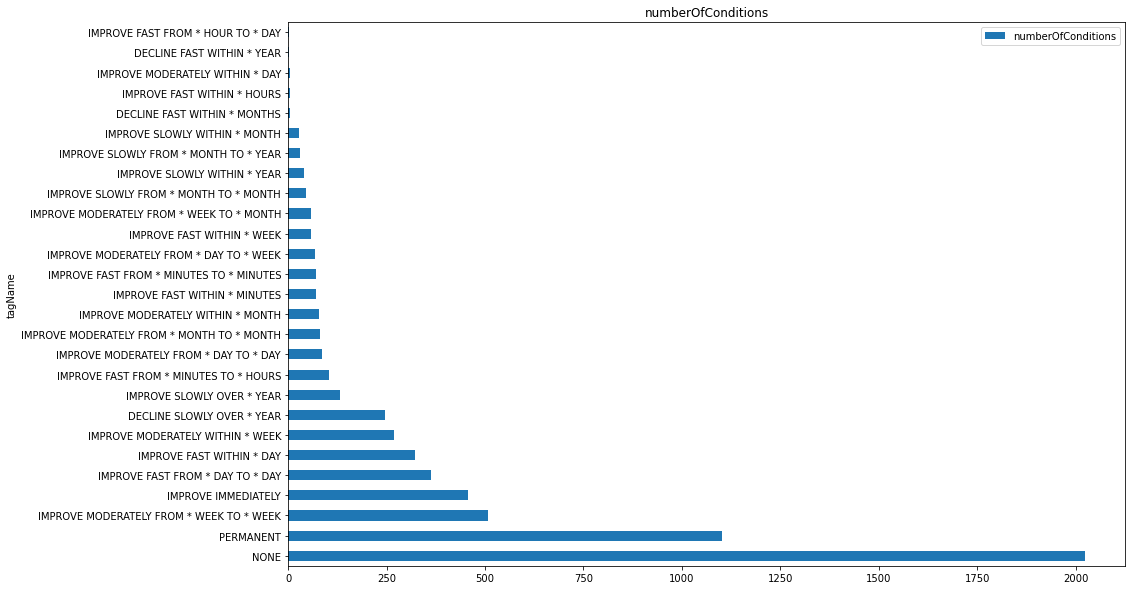

In [34]:
#fig = plt.figure(figsize=(20,15))
#fig = plt.figure()
ax = dfcpt.plot.barh(x='tagName',subplots=True,figsize=(15,10))#ylim=0)
#plt.show()

In [35]:
#total number of conditions that have N tags, 
#for example: 250 conditions have 1 tag, 494 have 2 tags
dfbynt = dftbc.groupby(['numberOfTags'],dropna=False).count()
dfbynt.info()
print(type(dfbynt))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   conditionName  11 non-null     int64
dtypes: int64(1)
memory usage: 176.0 bytes
<class 'pandas.core.frame.DataFrame'>


In [36]:
dfbynt.head(10)

,conditionName
numberOfTags,
1,331
2,523
3,496
4,299
5,187
6,113
7,38
8,21
9,8


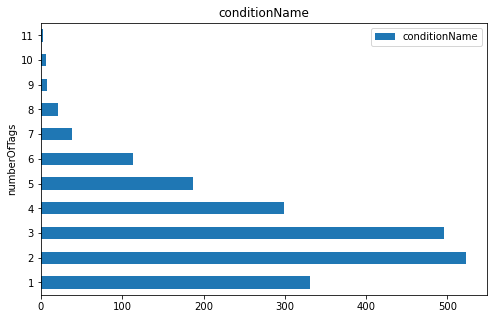

In [37]:
ax = dfbynt.plot.barh(y='conditionName',subplots=True,figsize=(8,5))#ylim=0)
#plt.show()

In [56]:
#Filtering conditions by # of tags: 
dfbynt = dfstats[dfstats.conditionName.isin(dftbc.query('numberOfTags==3').conditionName)]
print(dfbynt)

                            conditionName  \
4                           AAA screening   
5                           AAA screening   
6                           AAA screening   
16    Abdominal aortic aneurysm screening   
17    Abdominal aortic aneurysm screening   
...                                   ...   
6498                                X-ray   
6499                                X-ray   
6510                           Zika virus   
6511                           Zika virus   
6512                           Zika virus   

                                    predictedTag  Unnamed: 0  Unnamed: 0.1  \
4       IMPROVE FAST FROM * MINUTES TO * MINUTES           1           1.0   
5       IMPROVE MODERATELY FROM * WEEK TO * WEEK           1           1.0   
6                                           NONE          80          80.0   
16      IMPROVE FAST FROM * MINUTES TO * MINUTES           1           1.0   
17      IMPROVE MODERATELY FROM * WEEK TO * WEEK           1         

In [57]:
df_filtered = dftbc.query('numberOfTags==2')
print(df_filtered)

                       conditionName  numberOfTags
1236              Small bowel cancer             2
1237  Prosopagnosia (face blindness)             2
1238                  Rhesus disease             2
1239                 Fits (seizures)             2
1240                        Clubfoot             2
...                              ...           ...
1755              Gallbladder cancer             2
1756             Mesenteric ischemia             2
1757              Hip pain in adults             2
1758              Testicular torsion             2
1759       Interstitial lung disease             2

[524 rows x 2 columns]


In [58]:
df_filtered = dfstats.query('predictedTag=="NONE"')
print(df_filtered)
df_filtered.info()

                   conditionName predictedTag  Unnamed: 0  Unnamed: 0.1  \
3                            AAA         NONE         114         114.0   
6                  AAA screening         NONE          80          80.0   
8                     ACL injury         NONE         110         110.0   
9                           ARDS         NONE         113         113.0   
15     Abdominal aortic aneurysm         NONE         250         250.0   
...                          ...          ...         ...           ...   
6500   Yeast infection (vaginal)         NONE         119           NaN   
6506                Yellow fever         NONE         179           NaN   
6509                        Yips         NONE          49           NaN   
6512                  Zika virus         NONE         207           NaN   
6513  Zollinger-Ellison syndrome         NONE         113           NaN   

      source  sentence  
3        114       114  
6         80        80  
8        110       110  

#### Filter all the sentences that are different from NONE

In [59]:
#testSet reading the sentences that do not have a tag
for i in range(0,11,1):
    print(i)
    dfresults = pd.read_csv('02LR/'+str(date.today())+'_predictedSet'+str(i)+'.csv')
    dffilt = dfresults.query('predictedTag!="NONE"')
    
    if dffilt.empty == False:
        res = dffilt
        res.reset_index()
    else:
        dffilt.reset_index()
        res = res.append(dffilt)

res.to_csv('02LR/02'+str(date.today())+'_AllExceptNone.csv')


0
1
2
3
4
5
6
7
8
9
10


In [60]:
dfe = pd.read_csv('02LR/02'+str(date.today())+'_AllExceptNone.csv')
dfe.sort_values(['predictedTag','sentence'],  
               ascending=[True, 
                          True],inplace=True,ignore_index=True)
dfe.to_csv('02LR/02'+str(date.today())+'_AllExceptNone.csv')